In [23]:
import pandas as pd
from datasets import Dataset

# Load your parquet file
df = pd.read_parquet("../protein_embeddings.parquet")

# Assuming the parquet file has columns 'Sequence' and 'DMS_score'
dataset = Dataset.from_pandas(df[['Sequence', 'DMS_score']])


In [24]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

def tokenize_function(examples):
    return tokenizer(examples['Sequence'], padding="max_length", truncation=True, max_length=656)

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map: 100%|██████████| 1140/1140 [00:02<00:00, 485.89 examples/s]


In [56]:
tokenized_datasets

Dataset({
    features: ['Sequence', 'DMS_score', 'input_ids', 'attention_mask'],
    num_rows: 1140
})

In [55]:
from transformers import AutoModelForSequenceClassification
from peft import get_peft_model, LoraConfig

# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained("facebook/esm2_t33_650M_UR50D", num_labels=1)
print(model)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,

In [ ]:

# Set up LoRA configuration
lora_config = LoraConfig(
    r=16,  # Rank of the low-rank matrices
    lora_alpha=16,  # Scaling factor for LoRA updates
    lora_dropout=0.1,  # Dropout rate for LoRA
    target_modules=[
        # Targeting the query, key, and value layers within the attention
        "esm.encoder.layer.*.attention.self.query",  # Attention query layers
        "esm.encoder.layer.*.attention.self.key",    # Attention key layers
        "esm.encoder.layer.*.attention.self.value",  # Attention value layers
        "esm.encoder.layer.*.attention.output.dense", # Output dense layers in self-attention

        # Targeting the intermediate dense layers in the output
        "esm.encoder.layer.*.intermediate.dense",  # Intermediate layers
        "esm.encoder.layer.*.output.dense",  # Output dense layers in the intermediate

        # Targeting the final classifier layer
        "classifier.out_proj"  # Final output projection layer
    ],
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)


In [26]:
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader
from torch import nn

# Prepare the dataset for training
tokenized_datasets = tokenized_datasets.map(lambda e: {'labels': e['DMS_score']}, batched=True)
dataset_dict = tokenized_datasets.shuffle(seed=42).train_test_split(test_size=0.1)
train_dataset, eval_dataset = dataset_dict["train"], dataset_dict["test"]

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=lambda p: {'loss': nn.MSELoss()(p.predictions, p.label_ids).item()},
)

# Fine-tune the model
trainer.train()


Map: 100%|██████████| 1026/1026 [00:00<00:00, 50296.35 examples/s]
/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=645, training_loss=0.04448828290599261, metrics={'train_runtime': 1244.0279, 'train_samples_per_second': 4.124, 'train_steps_per_second': 0.518, 'total_flos': 1.314519151155264e+16, 'train_loss': 0.04448828290599261, 'epoch': 5.0})

In [27]:
# Save the fine-tuned model
trainer.save_model("./fine_tuned_model_lora")


In [44]:
predictions.predictions[0].shape

(129,)

In [45]:
predictions.predictions[1].shape

(1026, 1)

In [47]:
train_dataset

Dataset({
    features: ['Sequence', 'DMS_score', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1026
})

In [32]:
predictions = trainer.predict(train_dataset)
train_dataset


(array([0.02320602, 0.07012606, 0.03719847, 0.0814154 , 0.05918944,
       0.06345003, 0.04479254, 0.03773064, 0.04288913, 0.04651351,
       0.0593784 , 0.06546482, 0.02359401, 0.07063316, 0.04344887,
       0.0312431 , 0.02266061, 0.03800429, 0.05408122, 0.04618418,
       0.04266328, 0.07927297, 0.09347366, 0.02450255, 0.0418622 ,
       0.02149348, 0.01713691, 0.04141488, 0.02099298, 0.04800383,
       0.04439675, 0.0484485 , 0.02435333, 0.01967072, 0.02907022,
       0.02747432, 0.02450415, 0.02261062, 0.02971669, 0.0608567 ,
       0.07657106, 0.05419941, 0.04594339, 0.04337757, 0.08540905,
       0.02643153, 0.0159085 , 0.07169095, 0.07900331, 0.01668376,
       0.01260257, 0.02628579, 0.04824974, 0.08300337, 0.05522168,
       0.02525616, 0.02012382, 0.02640349, 0.0621426 , 0.02801889,
       0.01929567, 0.01620233, 0.02798562, 0.0203061 , 0.04237487,
       0.05137038, 0.1037002 , 0.05533183, 0.03933362, 0.04046097,
       0.03766076, 0.02784949, 0.03977851, 0.02413716, 0.1039

In [51]:
from scipy.stats import spearmanr
import numpy as np
# Extract predicted values and true labels
predicted_values = predictions.predictions[1].flatten()  # Flatten in case of multi-dimensional output
true_labels = train_dataset["labels"]

# predicted_values_normalized = (predicted_values - np.min(predicted_values)) / (np.max(predicted_values) - np.min(predicted_values))

# Compute Spearman correlation
corr, _ = spearmanr(predicted_values, true_labels)

# Output the correlation
print(f"Spearman correlation: {corr}")


Spearman correlation: 0.048977990473327494


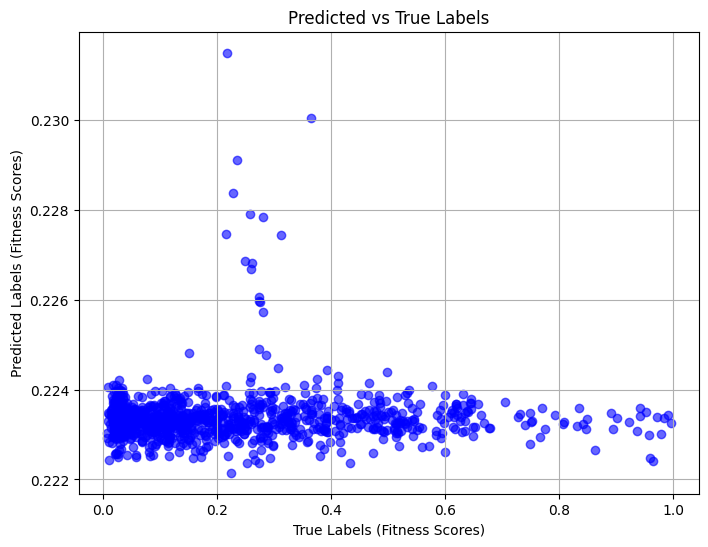

In [52]:
import matplotlib.pyplot as plt
# Visualize with a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(true_labels, predicted_values, alpha=0.6, color='b')
plt.title('Predicted vs True Labels')
plt.xlabel('True Labels (Fitness Scores)')
plt.ylabel('Predicted Labels (Fitness Scores)')
plt.grid(True)
plt.show()